In [2]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [3]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [4]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/JHUAPL-Bucky'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [5]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
len(all_data)

81

In [7]:
df2 = pd.concat(all_data)
df2.head(5)

,location,quantile,target,value,type,forecast_date,target_end_date
339,42,NaN,1 wk ahead inc case,3332.7885,point,2020-08-31,2020-09-05
3475,42,NaN,2 wk ahead inc case,3101.7830,point,2020-08-31,2020-09-12
6611,42,NaN,3 wk ahead inc case,2958.3330,point,2020-08-31,2020-09-19
9747,42,NaN,4 wk ahead inc case,2798.6660,point,2020-08-31,2020-09-26
339,42,NaN,1 wk ahead inc case,6235.7680,point,2020-09-07,2020-09-12


In [8]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [9]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

,location,quantile,target,value,type,forecast_date,target_end_date
339,42,NaN,1 wk ahead inc case,3332.788500,point,2020-08-31,2020-09-05
3475,42,NaN,2 wk ahead inc case,3101.783000,point,2020-08-31,2020-09-12
339,42,NaN,1 wk ahead inc case,6235.768000,point,2020-09-07,2020-09-12
6611,42,NaN,3 wk ahead inc case,2958.333000,point,2020-08-31,2020-09-19
3475,42,NaN,2 wk ahead inc case,6100.513000,point,2020-09-07,2020-09-19
...,...,...,...,...,...,...,...
13051,42,NaN,5 wk ahead inc case,5727.034220,point,2022-03-14,2022-04-16
16067,42,NaN,6 wk ahead inc case,3277.999171,point,2022-03-07,2022-04-16
19179,42,NaN,7 wk ahead inc case,2851.823910,point,2022-03-07,2022-04-23
16187,42,NaN,6 wk ahead inc case,5828.447788,point,2022-03-14,2022-04-23


In [10]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(81, 7)

In [11]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [12]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2022-02-15')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,location,quantile,target,value,type,forecast_date,dayRate
0,2020-09-05,42,NaN,1 wk ahead inc case,3332.7885,point,2020-08-31,476.112643
1,2020-09-12,42,NaN,1 wk ahead inc case,6235.7680,point,2020-09-07,890.824000
2,2020-09-19,42,NaN,1 wk ahead inc case,5325.1360,point,2020-09-14,760.733714
3,2020-09-26,42,NaN,1 wk ahead inc case,5984.2095,point,2020-09-21,854.887071
4,2020-10-03,42,NaN,1 wk ahead inc case,5496.9085,point,2020-09-28,785.272643


In [13]:
df_weekly.tail(5)

,Date,location,quantile,target,value,type,forecast_date,dayRate
71,2022-01-15,42,NaN,1 wk ahead inc case,264612.961459,point,2022-01-10,37801.851637
72,2022-01-22,42,NaN,1 wk ahead inc case,226668.810903,point,2022-01-17,32381.258700
73,2022-01-29,42,NaN,1 wk ahead inc case,107562.276229,point,2022-01-24,15366.039461
74,2022-02-05,42,NaN,1 wk ahead inc case,57656.694938,point,2022-01-31,8236.670705
75,2022-02-12,42,NaN,1 wk ahead inc case,31924.375256,point,2022-02-07,4560.625037


In [15]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
#del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[476.112642857143, 476.112642857143, 476.112642857143, 476.112642857143, 476.112642857143, 476.112642857143, 476.112642857143, 890.8240000000003, 890.8240000000003, 890.8240000000003, 890.8240000000003, 890.8240000000003, 890.8240000000003, 890.8240000000003, 760.7337142857143, 760.7337142857143, 760.7337142857143, 760.7337142857143, 760.7337142857143, 760.7337142857143, 760.7337142857143, 854.8870714285713, 854.8870714285713, 854.8870714285713, 854.8870714285713, 854.8870714285713, 854.8870714285713, 854.8870714285713, 785.2726428571431, 785.2726428571431, 785.2726428571431, 785.2726428571431, 785.2726428571431, 785.2726428571431, 785.2726428571431, 1026.604, 1026.604, 1026.604, 1026.604, 1026.604, 1026.604, 1026.604, 1179.6379550315648, 1179.6379550315648, 1179.6379550315648, 1179.6379550315648, 1179.6379550315648, 1179.6379550315648, 1179.6379550315648, 1353.462999146083, 1353.462999146083, 1353.462999146083, 1353.462999146083, 1353.462999146083, 1353.462999146083, 1353.462999146083

In [16]:
len(predictions)

532

In [20]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2020-09-05') & (df1['Date'] <= '2022-02-18')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2020-09-05,1310,1680.1,287560,25603978,270.1,357.0,46391.7,2860489,-5275.682283,2774.207671
1,2020-09-06,1196,1701.0,288756,25603978,271.4,366.6,46663.1,2860489,-5275.682283,2774.207671
2,2020-09-07,978,1603.0,289734,25603978,180.0,350.9,46842.2,2860489,-5275.682283,2774.207671
3,2020-09-08,1996,1630.4,291730,25603978,504.9,359.9,47347.2,2860489,-5275.682283,2774.207671
4,2020-09-09,1192,1491.0,292922,25603978,252.0,329.4,47599.1,2860489,-5275.682283,2774.207671


In [21]:
df1_copy.tail(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
527,2022-02-14,5636,7016.0,5461544,25603978,1863.7,2352.3,1499856.1,2860489,-5275.682283,2774.207671
528,2022-02-15,4890,6428.4,5466434,25603978,1790.6,2126.4,1501646.4,2860489,-5275.682283,2774.207671
529,2022-02-16,7384,6172.4,5473818,25603978,2262.0,2015.2,1503908.7,2860489,-5275.682283,2774.207671
530,2022-02-17,5988,5874.2,5479806,25603978,1984.3,1922.5,1505893.0,2860489,-5275.682283,2774.207671
531,2022-02-18,7464,5581.8,5487270,25603978,2514.5,1838.3,1508407.1,2860489,-5275.682283,2774.207671


In [22]:
len(df1_copy)

532

In [23]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [25]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [26]:
merged_df_new.shape

(532, 12)

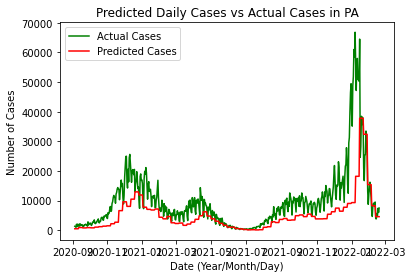

In [27]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [28]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

480
0.9022556390977443
52
0.09774436090225569
532
[0.6365552344601962, 0.6019125059722885, 0.5131772567922873, 0.7614666117950186, 0.60057664189837, 0.7675231236049107, 0.7517660881870997, 0.3168527607361961, 0.35634104046242754, 0.5917396883593032, 0.41776209150326776, 0.5286645502645501, 0.4521377613776136, 0.5105362637362636, 0.4398131706290764, 0.3373399701343952, 0.5556461949265687, 0.518522965641953, 0.5883475572047, 0.6237716546559277, 0.5879015632255069, 0.5302818288854004, 0.36581077787197974, 0.6962021778860799, 0.5159189856010356, 0.5874097145615004, 0.626686868371803, 0.6446853402208764, 0.5989414490004376, 0.5023620767698713, 0.5939645073127491, 0.7129851451545529, 0.6963369517180421, 0.7242722461878008, 0.7743469417077175, 0.5616549957301452, 0.5329372156505914, 0.609061690784463, 0.601473602484472, 0.6736795931341385, 0.6890963052695336, 0.7294138112809699, 0.539563639722262, 0.5216391098817661, 0.6170006639507907, 0.610680542893873, 0.7150632958860954, 0.728569269435903

In [29]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.36344476553980376, 0.3980874940277115, 0.4868227432077127, 0.23853338820498138, 0.39942335810163, 0.2324768763950893, 0.24823391181290033, 0.6831472392638038, 0.6436589595375725, 0.40826031164069676, 0.5822379084967322, 0.47133544973544994, 0.5478622386223864, 0.4894637362637364, 0.5601868293709236, 0.6626600298656048, 0.44435380507343125, 0.481477034358047, 0.4116524427953, 0.37622834534407235, 0.4120984367744931, 0.46971817111459957, 0.6341892221280203, 0.30379782211392015, 0.48408101439896445, 0.4125902854384996, 0.373313131628197, 0.3553146597791236, 0.40105855099956245, 0.4976379232301287, 0.4060354926872509, 0.2870148548454471, 0.3036630482819579, 0.27572775381219916, 0.22565305829228255, 0.4383450042698548, 0.4670627843494086, 0.39093830921553696, 0.398526397515528, 0.3263204068658615, 0.3109036947304664, 0.27058618871903006, 0.46043636027773804, 0.4783608901182339, 0.3829993360492093, 0.38931945710612703, 0.2849367041139046, 0.27143073056409683, 0.2729379812659799, 0.3867037

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

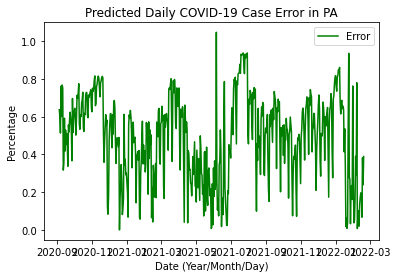

In [31]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

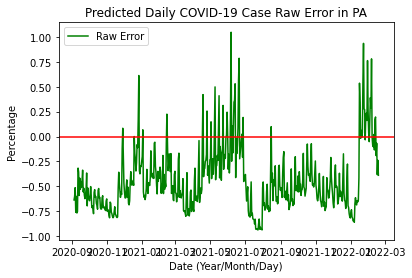

In [32]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

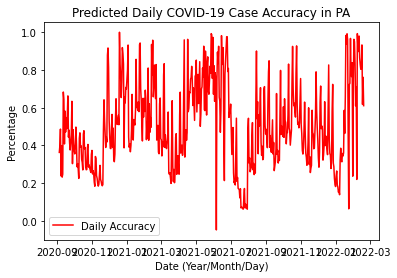

In [33]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [39]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [40]:
len(weeklyDateList)

77

In [41]:
#del averageWeeklyAccuracy[-1:]
len(averageWeeklyAccuracy)

76

In [42]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

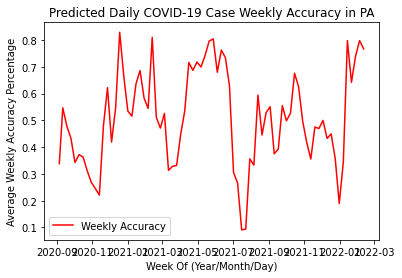

In [43]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [44]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [45]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

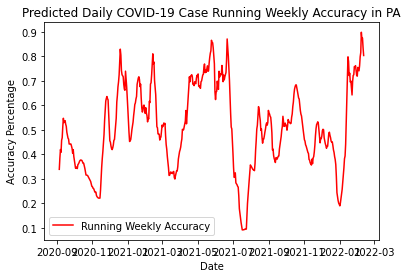

In [46]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

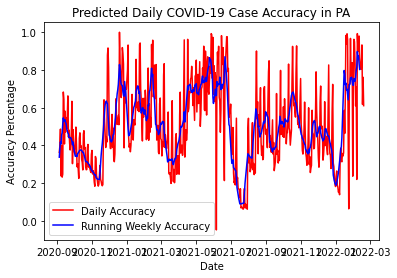

In [47]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [50]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [51]:
#del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

18

In [52]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

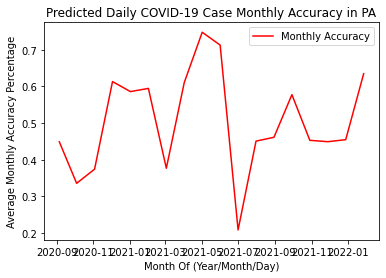

In [53]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [54]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [55]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

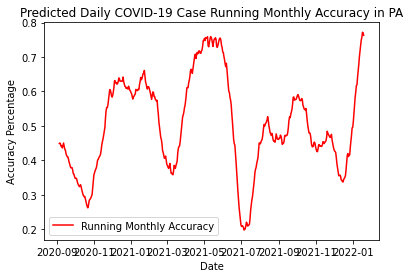

In [56]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [57]:
#Calculate Yearly Accuracy Averages
#We are going to use an average of 365 days per year for these calculations

yearlyAccuracy = 0
averageYearlyAccuracy = []
amountOfYears = int(length / 365)
remainderDays = length % 365

i = 0
while i < length:
  yearlyAccuracy += accuracy[i]
  if (i + 1) % 365 == 0 and amountOfYears > 0:
    averageYearlyAccuracy.append(yearlyAccuracy / 365)
    amountOfYears -= 1
    yearlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfYears == 0:
    averageYearlyAccuracy.append(yearlyAccuracy / remainderDays)
    yearlyAccuracy = 0
  i += 1

weeklyDateListForYears = []
i = 0
weeklyDateListForYears.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 365 == 0:
    weeklyDateListForYears.append(merged_df_new['Date'][i])
  i += 1

In [58]:
print(averageYearlyAccuracy)

[0.5047497367044826, 0.37633534301555777]


In [59]:
#Create Dataframe for Yearly Accuracy
i = 0
data = []
while i < len(averageYearlyAccuracy):
  data.append([weeklyDateListForYears[i], averageYearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Year Of', 'Average Yearly Accuracy'])

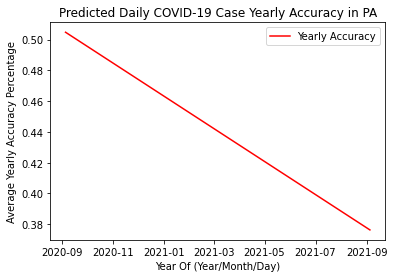

In [60]:
#Create plot of Yearly Accuracy

#Accuracy Line
plt.plot(df['Year Of'], df['Average Yearly Accuracy'], color='r', label='Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Year Of (Year/Month/Day)') 
plt.ylabel('Average Yearly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [61]:
#Calculate Running Yearly Accuracy

runningyearlyAccuracy = 0
runningAverageyearlyAccuracy = []
length = len(accuracy)

i = 1
j = 366
#Add first week average
runningAverageyearlyAccuracy.append(averageYearlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningyearlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageyearlyAccuracy.append(runningyearlyAccuracy / 365)
  runningyearlyAccuracy = 0

  i += 1
  j += 1

In [62]:
#Create Dataframe for Running Yearly Accuracy
i = 0
data = []
while i < len(runningAverageyearlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageyearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Yearly Average Accuracy'])

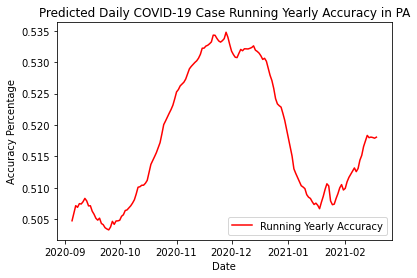

In [63]:
#Create plot of Running Yearly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Yearly Average Accuracy'], color='r', label='Running Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [64]:
#Calculate Overall Accuracy
overallAccuracy = merged_df_new['Accuracy'].mean()
print(overallAccuracy)

0.5086195720659824


In [65]:
#Create new dataframe for year 2022
data_2022 = merged_df_new[(merged_df_new['Date'] > '2022-01-01')]

In [66]:
#create error and accuracy lists for 2022
error_2022=[]
for index, row in data_2022.iterrows():
  error_2022.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

accuracy_2022 = []
for i in error_2022:
  accuracy_2022.append(1 - i)

In [67]:
#check head of 2022 data
data_2022.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction,Error,Accuracy,RawError
484,2022-01-02,35128,38695.9,4203914,25603978,6449.2,7426.4,1172327.7,2860489,-5275.682283,2774.207671,9309.599908,0.734981,0.265019,-0.734981
485,2022-01-03,48768,41456.9,4252682,25603978,9816.9,8055.2,1182144.5,2860489,-5275.682283,2774.207671,9309.599908,0.809104,0.190896,-0.809104
486,2022-01-04,51898,44396.0,4304580,25603978,10744.4,8691.2,1192888.2,2860489,-5275.682283,2774.207671,9309.599908,0.820617,0.179383,-0.820617
487,2022-01-05,61004,47411.2,4365584,25603978,11662.5,9215.5,1204551.4,2860489,-5275.682283,2774.207671,9309.599908,0.847394,0.152606,-0.847394
488,2022-01-06,58492,49136.1,4424076,25603978,12854.6,9728.8,1217406.1,2860489,-5275.682283,2774.207671,9309.599908,0.840840,0.159160,-0.840840


([<matplotlib.axis.XTick at 0x7f394bef70d0>,
 <a list of 7 Text major ticklabel objects>)

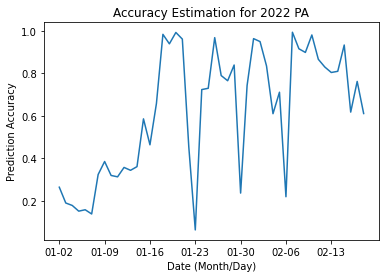

In [68]:
#create plot for 2022 accuracy
plt.xlabel('Date (Month/Day)') 
plt.ylabel('Prediction Accuracy') 
plt.title("Accuracy Estimation for 2022 PA")

plt.plot(data_2022['Date'].dt.strftime('%m-%d'), accuracy_2022, label='Accuracy 2022')
plt.xticks(np.arange(0, len(data_2022['Date']), 7))

In [69]:
#cleans accuracy list of all nan values
newlist = [x for x in accuracy if math.isnan(x) == False]
print(newlist)

[0.36344476553980376, 0.3980874940277115, 0.4868227432077127, 0.23853338820498138, 0.39942335810163, 0.2324768763950893, 0.24823391181290033, 0.6831472392638038, 0.6436589595375725, 0.40826031164069676, 0.5822379084967322, 0.47133544973544994, 0.5478622386223864, 0.4894637362637364, 0.5601868293709236, 0.6626600298656048, 0.44435380507343125, 0.481477034358047, 0.4116524427953, 0.37622834534407235, 0.4120984367744931, 0.46971817111459957, 0.6341892221280203, 0.30379782211392015, 0.48408101439896445, 0.4125902854384996, 0.373313131628197, 0.3553146597791236, 0.40105855099956245, 0.4976379232301287, 0.4060354926872509, 0.2870148548454471, 0.3036630482819579, 0.27572775381219916, 0.22565305829228255, 0.4383450042698548, 0.4670627843494086, 0.39093830921553696, 0.398526397515528, 0.3263204068658615, 0.3109036947304664, 0.27058618871903006, 0.46043636027773804, 0.4783608901182339, 0.3829993360492093, 0.38931945710612703, 0.2849367041139046, 0.27143073056409683, 0.2729379812659799, 0.3867037

In [70]:
#calculate variance and st deviation of accuracy
var = sum((l-overallAccuracy)**2 for l in newlist) / len(newlist)
st_dev = math.sqrt(var)
print(var)
print(st_dev)

0.05001635037565467
0.2236433553129953


In [71]:
#calculate median of accuracy
accMedian = statistics.median(newlist)
print(accMedian)

0.4762222390410209


In [72]:
#Seperate Running Weekly Average plot into 3 plots for the 3 variants: Original, Delta, Omicron

# Start Date - May 20th 2021
# Delta: May 20th 2021 - December 1st 2021
# Omicron: December 1st 2021 - Present

In [73]:
type(merged_df_new['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [74]:
merged_df_new.index[merged_df_new['Date']=='2021-05-20'].tolist()

[257]

In [75]:
merged_df_new.index[merged_df_new['Date']=='2021-12-01'].tolist()

[452]

In [76]:
#print(merged_inner)
standardVariantDF = merged_df_new[:257]
deltaVariantDF = merged_df_new[257:452]
omicronVariantDF = merged_df_new[452:]

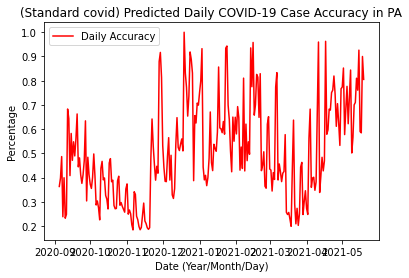

In [77]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(standardVariantDF['Date'], standardVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Standard covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

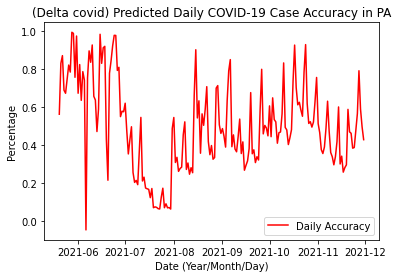

In [78]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(deltaVariantDF['Date'], deltaVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Delta covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

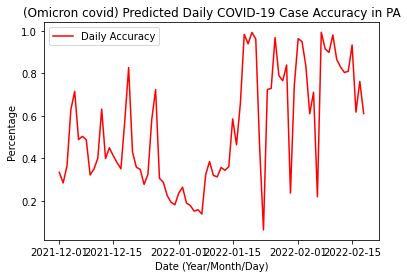

In [79]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(omicronVariantDF['Date'], omicronVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Omicron covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()